## OBJECTIVE :

### Predicting text emotions

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import sys
import ipdb
import numpy as np
import pandas as pd
import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import sent_tokenize, word_tokenize

print("Numpy Version : ", np.__version__)
print("Pandas Version : ", pd.__version__)

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Matplotlib Version : ", mpl.__version__)

Numpy Version :  1.18.1
Pandas Version :  1.0.1
Matplotlib Version :  3.1.3


In [3]:
# Initializing spacy model
nlp = spacy.load('en_core_web_md')

In [4]:
DATA_DIR = "../data/"
OBJECT_DIR = "../objects/"
LOG_DIR = "../logs/"

In [5]:
LUCKY_SEED = 42

In [6]:
ORIG_DATA_DIR = os.path.join(DATA_DIR, "orig_data/sa-emotions")
TRAIN_DIR = os.path.join(DATA_DIR, "training_data")
VALID_DIR = os.path.join(DATA_DIR, "validation_data")
TEST_DIR = os.path.join(DATA_DIR, "testing_data")

In [16]:
STOPWORDS = nlp.Defaults.stop_words.union(STOPWORDS)
KEEPWORDS = ['up', 'down', 'no', 'not', 'nothing', 'none', 'neither', 'never', 'except', 'below', 'bottom', 'without', 'serious', \
            'really', 'above', 'against', 'cannot', 'least', 'less', 'more', 'most', 'must', 'top', 'well']
for word in KEEPWORDS:
    STOPWORDS.remove(word)
STOPWORDS = list(STOPWORDS)
DATE_STOPWORDS = ['january', 'february', 'march', 'april', 'may', 'june', \
                  'july', 'august', 'september', 'october', 'november', 'december', \
                 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', \
                 'today', 'tomorrow', 'yesterday', 'year', 'month', 'date', 'day']
NUM_STOPWORDS = ['hundred', 'hundreds', 'thousand', 'thousands', 'million', 'millions', 'billion', 'billions']
REL_STOPWORDS = ['brother', 'sister', 'son', 'daughter', 'father', 'mother', 'uncle', 'aunt', 'aunty', 'wife', \
                 'husband', 'cousin', 'nephew', 'niece', 'child', 'dad', 'mom', 'papa', 'mummy', 'bro', 'sis', \
                 'grandfather', 'grandmother', 'granny', 'grandpa', 'grandma', 'children', 'boy', 'boys', 'guy', \
                 'guys', 'girl', 'girls', 'man', 'men', 'woman', 'women']
DIR_STOPWORDS = ['north', 'south', 'east', 'west']
STOPWORDS += DATE_STOPWORDS + NUM_STOPWORDS + REL_STOPWORDS + DIR_STOPWORDS
STOPWORDS = set(STOPWORDS)
print(len(STOPWORDS))

435


In [20]:
# Read data
data = pd.read_csv(os.path.join(ORIG_DATA_DIR, "train_data.csv"))

In [21]:
data.shape

(30000, 2)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  30000 non-null  object
 1   content    30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB


In [23]:
data.head()

sentiment                                            content
0       empty  @tiffanylue i know  i was listenin to bad habi...
1     sadness  Layin n bed with a headache  ughhhh...waitin o...
2     sadness                Funeral ceremony...gloomy friday...
3  enthusiasm               wants to hang out with friends SOON!
4     neutral  @dannycastillo We want to trade with someone w...

In [83]:
# Read test data
test_data = pd.read_csv(os.path.join(ORIG_DATA_DIR, "test_data.csv"))
print("Shape of test data : {}".format(test_data.shape))
print()
print("Features in test data : {}".format(test_data.columns.values))
print()
print("Test Dataframe Information : ")
test_data.info()

Shape of test data : (10000, 2)

Features in test data : ['id' 'content']

Test Dataframe Information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       10000 non-null  int64 
 1   content  10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


#### Analysis of training data

In [60]:
data.drop_duplicates(subset="content").shape, data.shape, data.drop_duplicates().shape

((29939, 4), (30000, 4), (29977, 4))

In [61]:
data[data["content"].duplicated()][["content", "sentiment"]]

content  sentiment
366           I feel so deflated. No more doggy.      worry
521        Somebody please save the polar bears!      worry
1026                                 I'm at work    neutral
3684   @dublins98dave me too! I am down 400 euro    sadness
4363     is upset, I left my phone at home again      worry
...                                          ...        ...
27883                                Goodmorning  happiness
27904                    may the 4th be with you    neutral
28202                               Good Morning       love
28874                              good morning!    neutral
29869                                          0    neutral

[61 rows x 2 columns]

In [62]:
data = data.drop_duplicates(subset="content").reset_index(drop=True)

In [64]:
data["sentiment"].value_counts()

worry         7418
neutral       6322
sadness       4818
happiness     2981
love          2062
surprise      1609
hate          1187
fun           1088
relief        1020
empty          657
enthusiasm     522
boredom        157
anger           98
Name: sentiment, dtype: int64

Different types of emotions and their counts : 


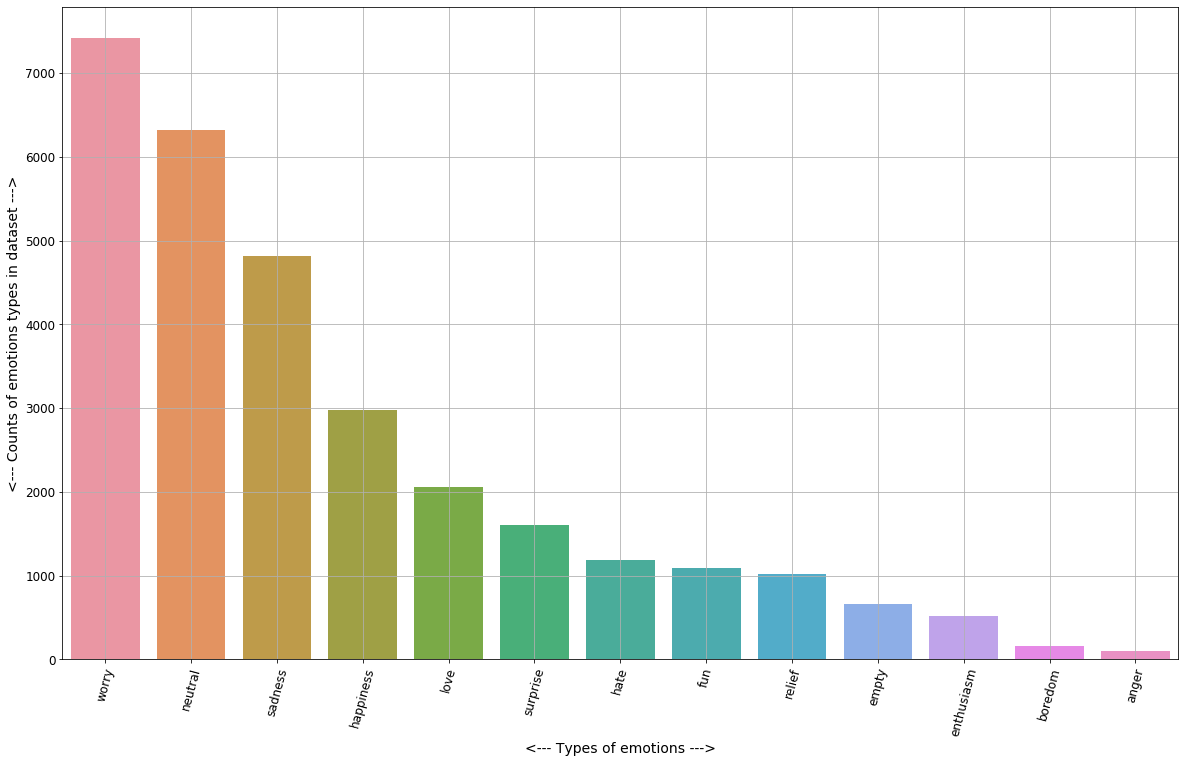

In [63]:
print('Different types of emotions and their counts : ')
fig_dims = (20, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data['sentiment'].value_counts().index, data['sentiment'].value_counts().values)
plt.xticks(rotation=75)
plt.grid()
plt.xlabel('<--- Types of emotions --->')
plt.ylabel('<--- Counts of emotions types in dataset --->')
plt.show()

In [65]:
data["lcased_text"] = data["content"].map(lambda x:x.lower())

In [66]:
def create_wordcloud(sentences, label):
    print("Target Type : ", label)
    fig_dims = (20, 12)
    text = ' '.join(sentences) 
    wordcloud = WordCloud(stopwords=STOPWORDS, max_words=200, background_color="white").generate(text)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def get_word_count(text):
    word_count = 0
    sentences = sent_tokenize(text)
    for sen in sentences:
        word_count += len(word_tokenize(sen))
    return word_count

In [67]:
data["word_count"] = data["lcased_text"].map(get_word_count)

Target Type :  Worry Tweets


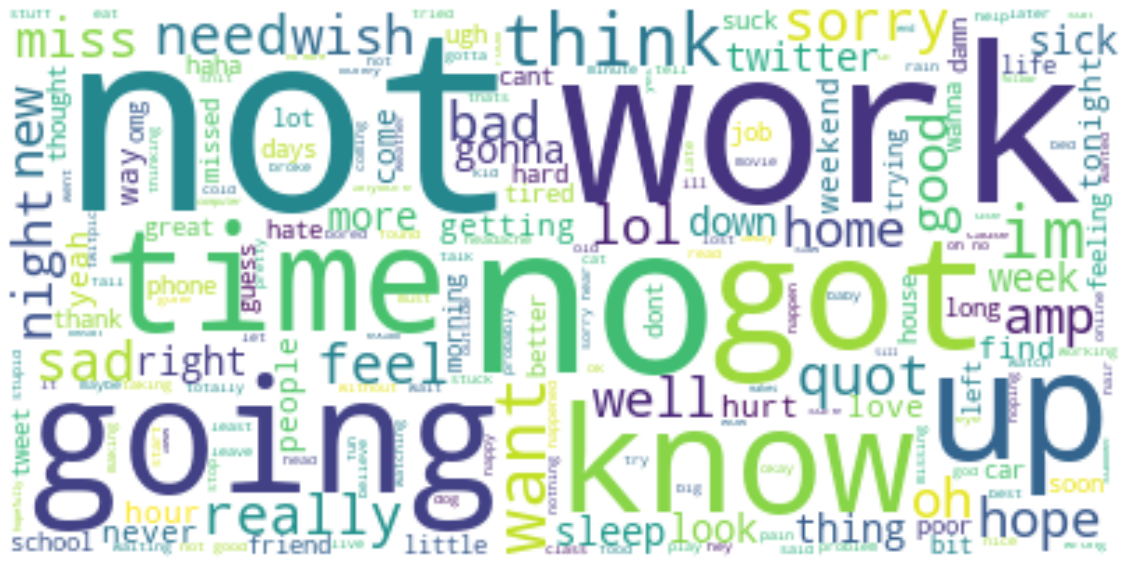

In [68]:
create_wordcloud(data.loc[data["sentiment"]=="worry", "lcased_text"].values, "Worry Tweets")

Target Type :  Neutral Tweets


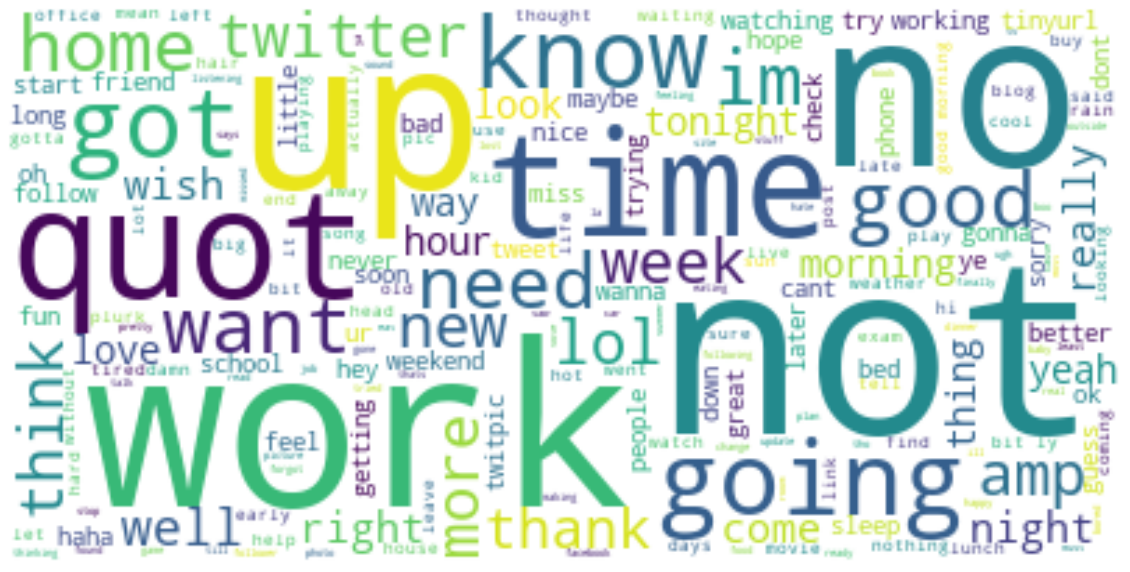

In [69]:
create_wordcloud(data.loc[data["sentiment"]=="neutral", "lcased_text"].values, "Neutral Tweets")

Target Type :  Sadness Tweets


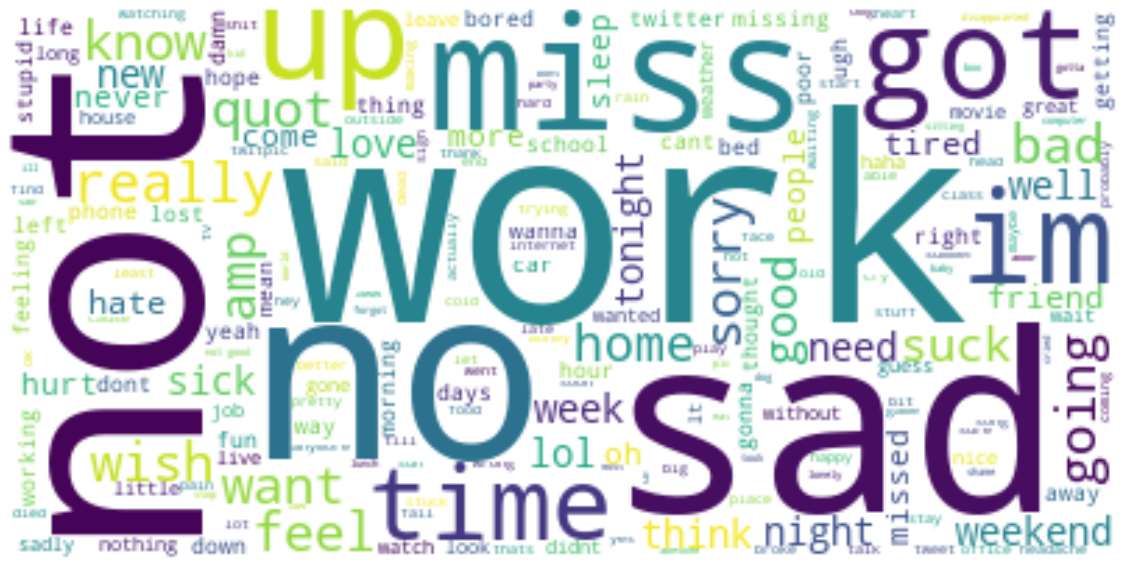

In [70]:
create_wordcloud(data.loc[data["sentiment"]=="sadness", "lcased_text"].values, "Sadness Tweets")

Target Type :  Happiness Tweets


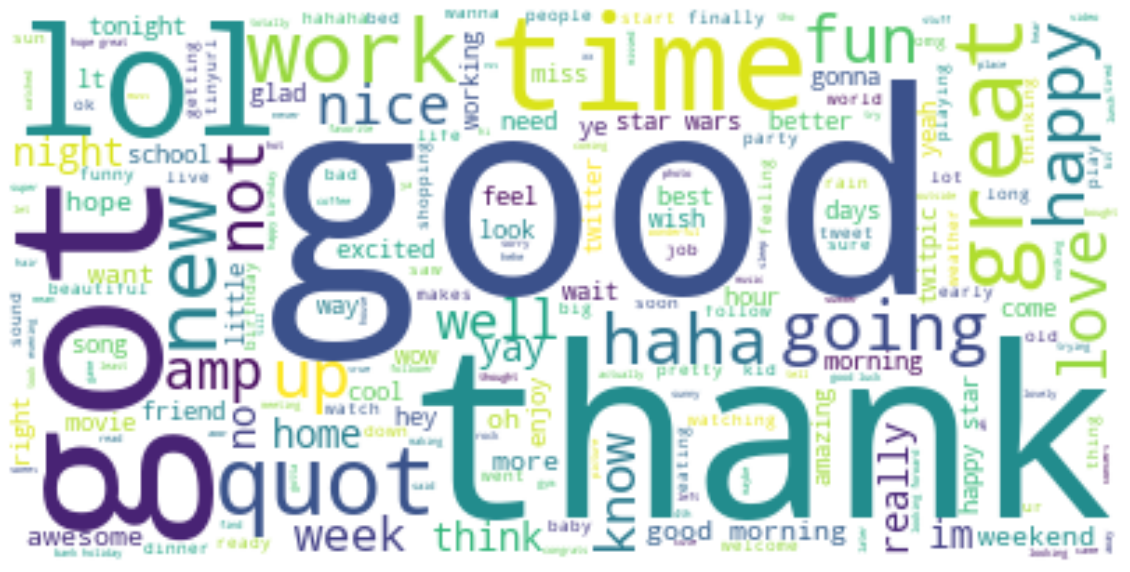

In [71]:
create_wordcloud(data.loc[data["sentiment"]=="happiness", "lcased_text"].values, "Happiness Tweets")

Target Type :  Love Tweets


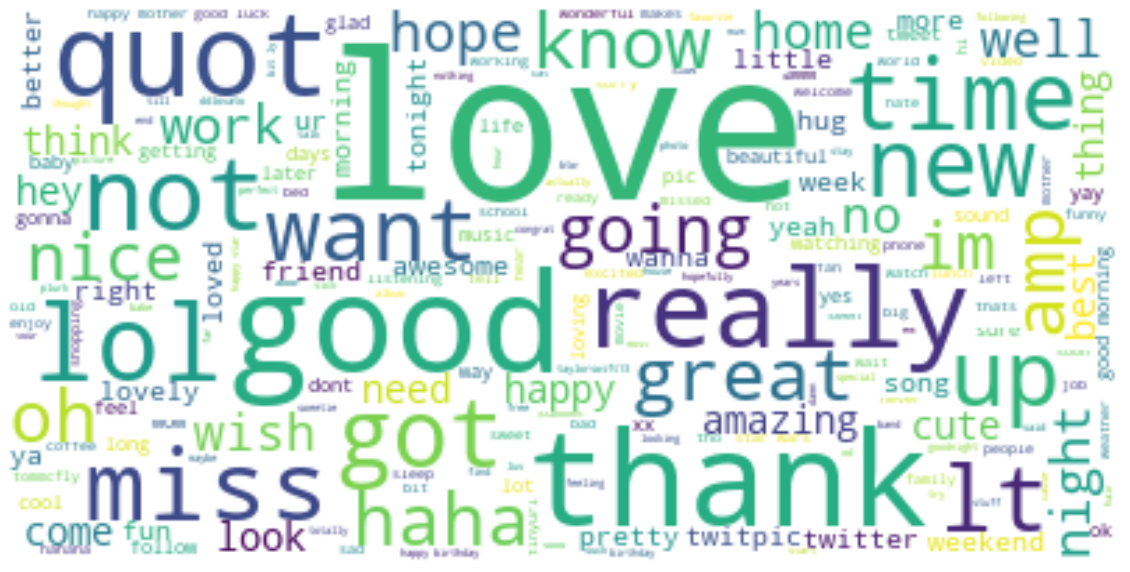

In [72]:
create_wordcloud(data.loc[data["sentiment"]=="love", "lcased_text"].values, "Love Tweets")

Target Type :  Surprise Tweets


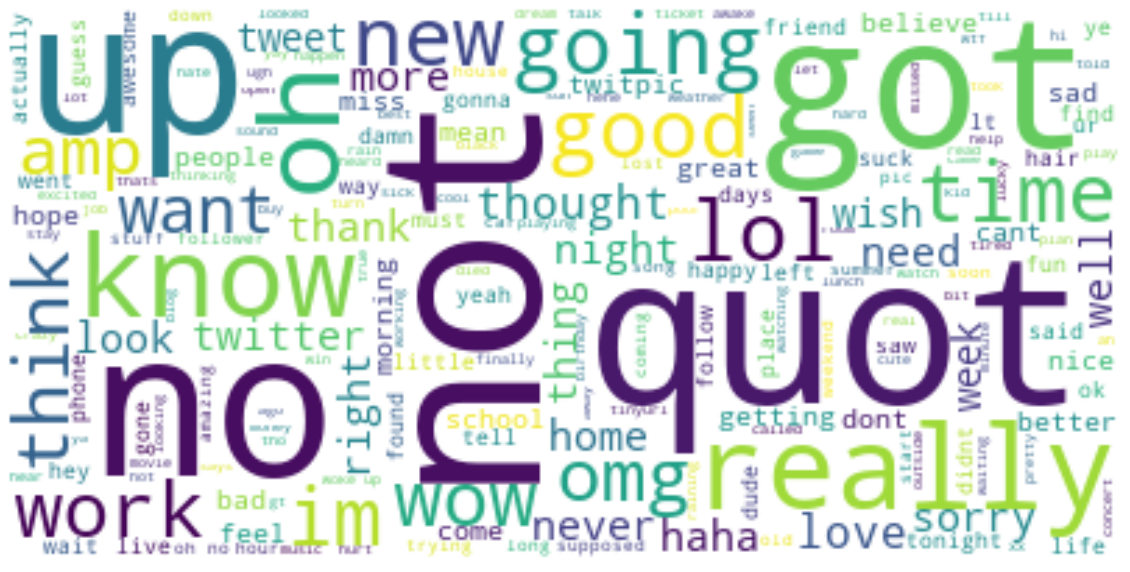

In [73]:
create_wordcloud(data.loc[data["sentiment"]=="surprise", "lcased_text"].values, "Surprise Tweets")

Target Type :  Hate Tweets


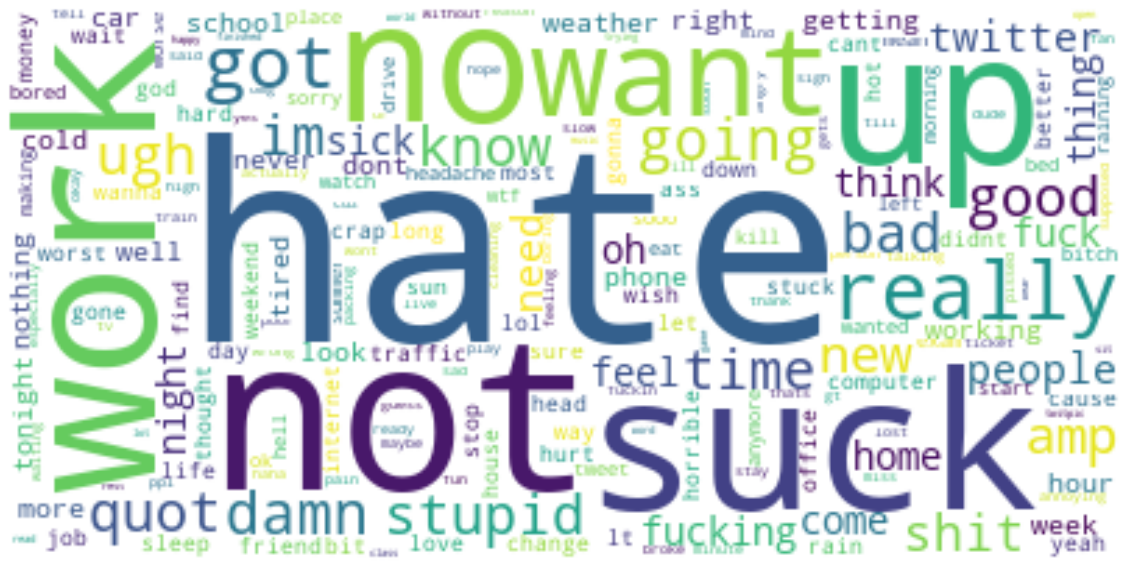

In [74]:
create_wordcloud(data.loc[data["sentiment"]=="hate", "lcased_text"].values, "Hate Tweets")

Target Type :  Fun Tweets


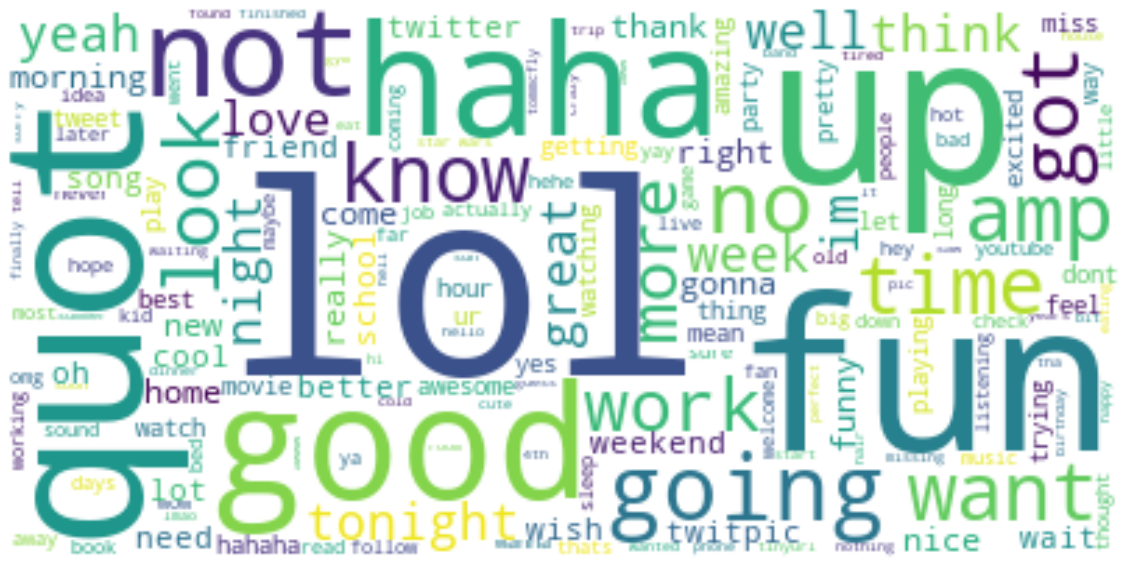

In [75]:
create_wordcloud(data.loc[data["sentiment"]=="fun", "lcased_text"].values, "Fun Tweets")

Target Type :  Relief Tweets


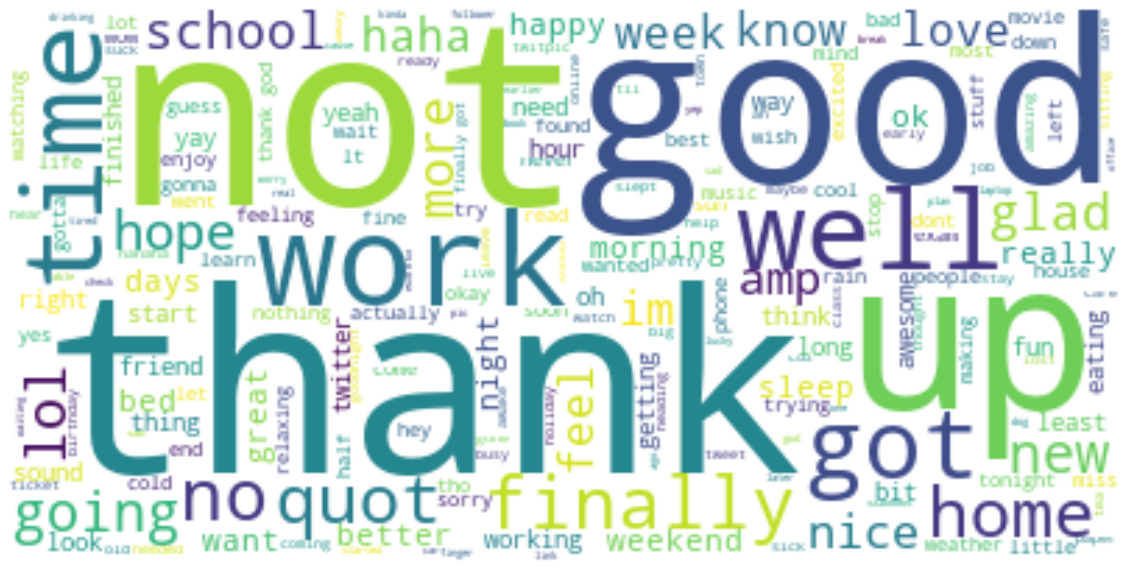

In [76]:
create_wordcloud(data.loc[data["sentiment"]=="relief", "lcased_text"].values, "Relief Tweets")

Target Type :  Empty Tweets


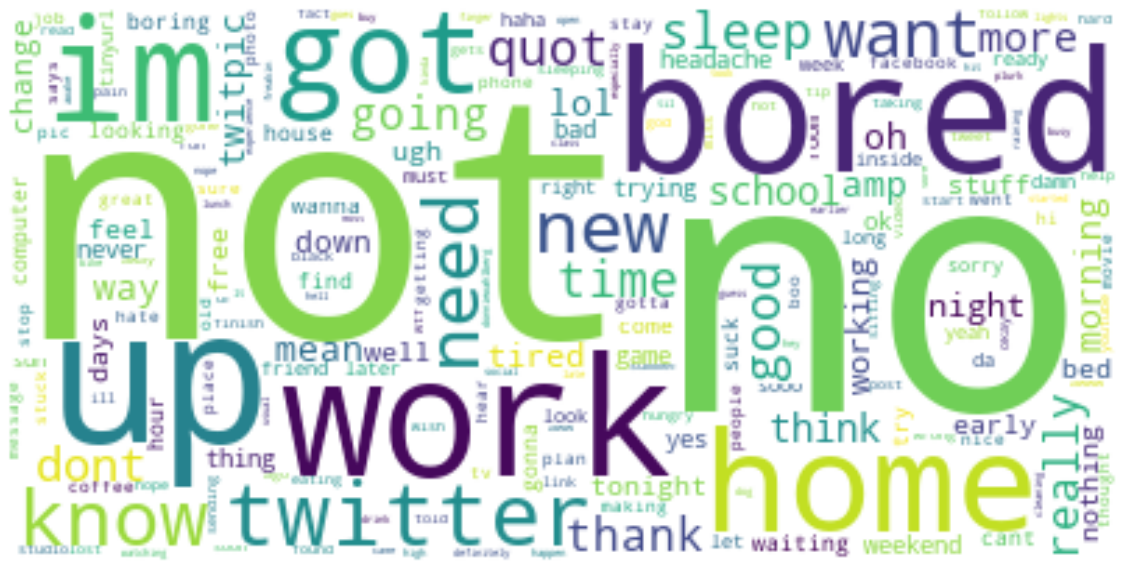

In [77]:
create_wordcloud(data.loc[data["sentiment"]=="empty", "lcased_text"].values, "Empty Tweets")

Target Type :  Enthusiasm Tweets


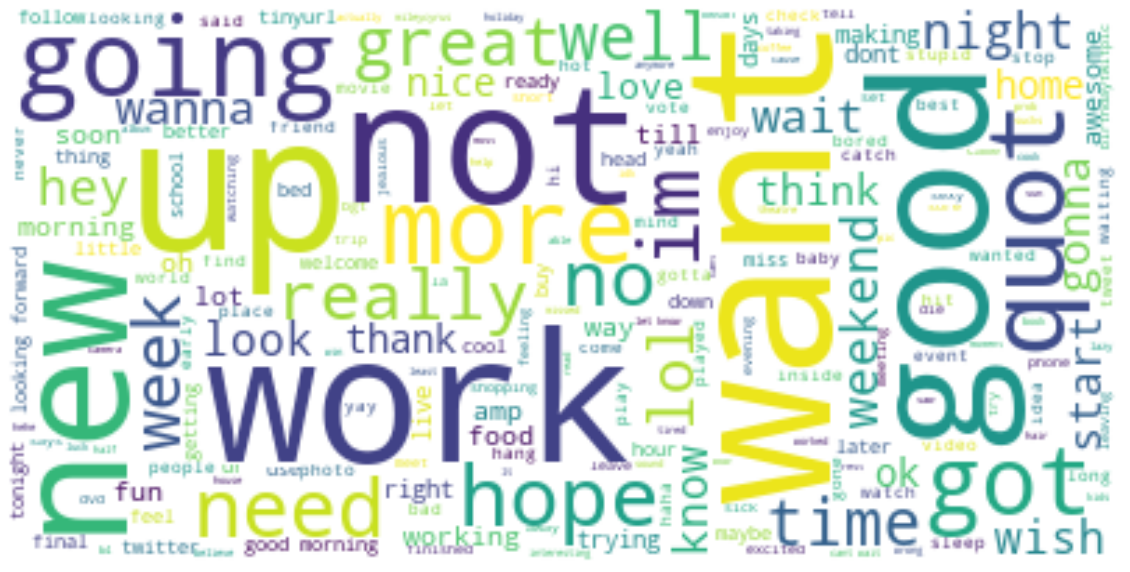

In [78]:
create_wordcloud(data.loc[data["sentiment"]=="enthusiasm", "lcased_text"].values, "Enthusiasm Tweets")

Target Type :  Boredom Tweets


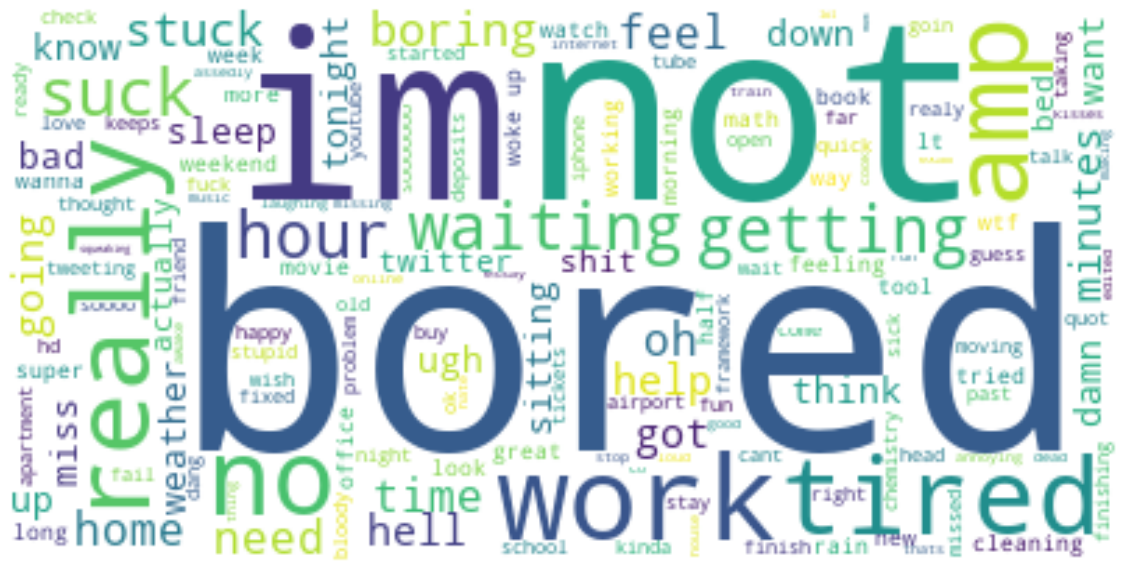

In [79]:
create_wordcloud(data.loc[data["sentiment"]=="boredom", "lcased_text"].values, "Boredom Tweets")

Target Type :  Anger Tweets


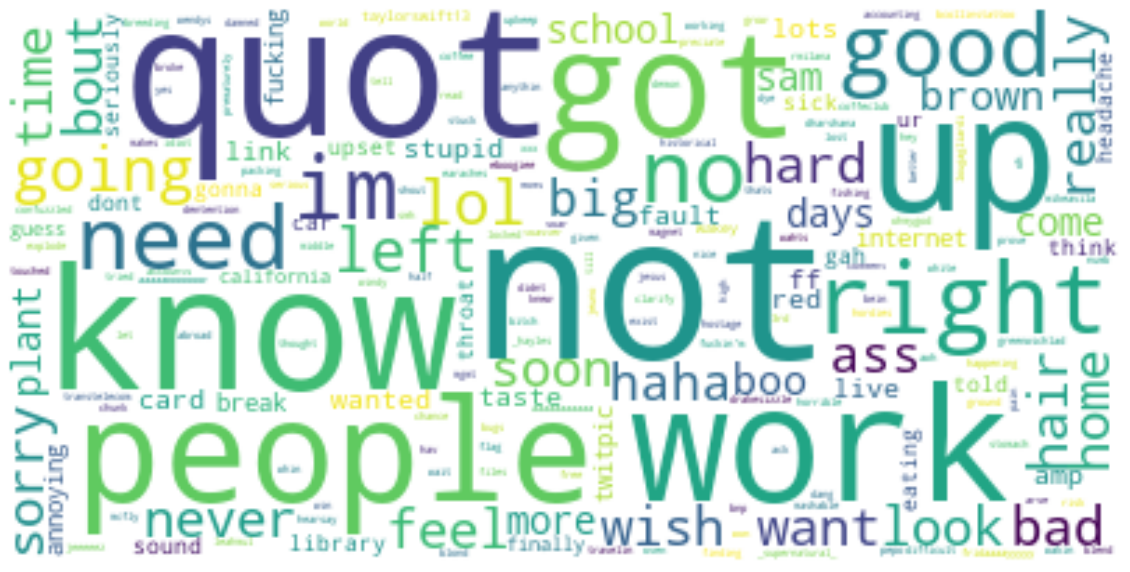

In [80]:
create_wordcloud(data.loc[data["sentiment"]=="anger", "lcased_text"].values, "Anger Tweets")